In [1]:
import numpy as np
import matplotlib.pyplot as plt

/home/marcello/anaconda3/lib/python3.9/site-packages/numpy/_core/getlimits.py:545: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
# cutoff for s to actually increase h to reduce refuse
S_BIG = 1.2

def RK( f, t0, y0, h, s,a,b,c):
    # general runge kutta for a given sabc
    # not very efficient
    t = np.zeros(s)
    y = np.zeros(s)
    k = np.zeros(s)
    for i in range(s):
        y[i] = y0
        for j in range(i):
            y[i] += h * a[i,j] * k[j]
        t[i] = t0 + c[i] * h
        k[i] = f(t[i],y[i])
    t = t0 + h
    y = y0 + h * np.dot(b[:s],k)
    return t,y

def RKF( f, t, y, h, tol ):
    # https://doi.org/10.1007/BF02234758
    # https://maths.cnam.fr/IMG/pdf/RungeKuttaFehlbergProof.pdf
    # https://en.wikipedia.org/wiki/Runge-Kutta-Fehlberg_method
    # Evaluate y twice using the same k points
    # from their difference, evaluate the goodness s of the step
    a45 = np.array([
        [                                                     0,0,0,0,0,0],
        [ 1/4                                                  ,0,0,0,0,0],
        [ 3/32     ,    9/32                                     ,0,0,0,0],
        [ 1932/2197,-7200/2197 , 7296/2197                         ,0,0,0],
        [  439/216 ,   -8      , 3680/513  , -845/4104               ,0,0],
        [   -8/27  ,    2      ,-3544/2565 , 1859/4104, -11/40         ,0]
    ])

    b4 = np.array([25/216, 0, 1408/2565, 2197/4104, -1/5])
    b5 = np.array([16/135, 0, 6656/12825, 28561/56430, -9/50, 2/55])
    c45 = np.array([0,1/4,3/8,12/13,1,1/2])
    # A real code would reuse the k, instead of computing them twice
    _, y4 = RK( f, t, y, h, 5, a45, b4, c45 ) # had to increase s by 1 # ??
    _, y5 = RK( f, t, y, h, 6, a45, b5, c45 )
    
    if y4 != y5:
        s = ( tol/(2*np.abs(y4-y5)))**0.25
    else:
        s = S_BIG
        
    return t+h, y5, s

def solve_ODE( f, t0, y0, h0, max_t, tol ):
    
    # f: derivative of the function g to solve for, such that d/dt y = f
    # t0, y0 : starting values, so that y(t=t0) = y0
    # h0: initial guess for the best step
    # max_t: max value for t to solve for
    # tol: ~ tolerance~ 
    # Speculation: for a linear ODE, tol + tol(t-t0) + tol * y (?)
    # should be the distance from the exact solution
    # Speculation: maybe, tol + tol(t-t0) + tol * int from t0 to t of y
    
    # from the starting y0 and t0, with a guess from the user of h0,
    #
    # (1) test if the current h, called hx, is valid for the current
    # t and y, called tx and yx. Save the new (trial) y and t in 
    # tx_ and yx_
    #
    # (2) if s (called sx) is less than one it means that the h was too ambitous.
    # in that case, refuse the step, reduce h and go back to the start
    # (3) if h was ok, add the new point
    # (4) update h, within limits
    
    tx,yx,hx = t0,y0,h0
    ttx = [tx]
    yyx = [yx]
    hhx = [hx]

    i = 0
    while tx < max_t:

        if tx + hx > max_t:
            hx = max_t - tx
            
        tx_,yx_,sx = RKF(problem,tx,yx,hx, tol)
        i += 1
                
        if sx < 1.:
            hx *= sx
        else:
            tx = tx_
            yx = yx_
            ttx.append(tx)
            yyx.append(yx)
            hhx.append(hx)

        if sx > S_BIG:
#            hx *= min( np.sqrt(S_BIG), np.sqrt(sx) )
            hx *= min( S_BIG, sx )

    hhx = np.array(hhx)
    ttx = np.array(ttx)
    yyx = np.array(yyx)
    
    print("Solve ODE tested ", i, " times for ", len(hhx), " accepted values and ", len(hhx)*6, " evaluation of f")
    return ttx, yyx, hhx


    


In [3]:

def problem( t, y ):
# 6 #    return - 12 * y * np.sin(12 * t)
# 5 #    return y - t*t
# 4 #    return y - t
#    return - 15 * y - y / 15 + np.sin(t)
    return - 15 * y
# 1 #    return - y + np.sin(t)

def solution( t ):
# 6 #    return np.exp(np.cos(12*t)-1)
# 5 #    return t*t + 2 * t - np.exp(t) + 2
# 4 #    return t + 1
#    return (51526. * np.exp(-(226*t)/15) - 225*np.cos(t) + 3390*np.sin(t))/51301
    return np.exp(-15. * t)
# 1 #    return 1/2 * ( -np.cos(t) + np.exp(1. - t) * (2. + np.cos(1.) - np.sin(1.)) + np.sin(t))


## note that changing to and y0 may break the analytical solutions
t0 = 0.
y0 = 1.
## h0, tol and max_t can be changed 
h0 = 0.1
tol = 1.e-13
max_t = 2


t, y, h = solve_ODE( problem, t0, y0, h0, max_t, tol )


Solve ODE tested  683  times for  662  accepted values and  3972  evaluation of f


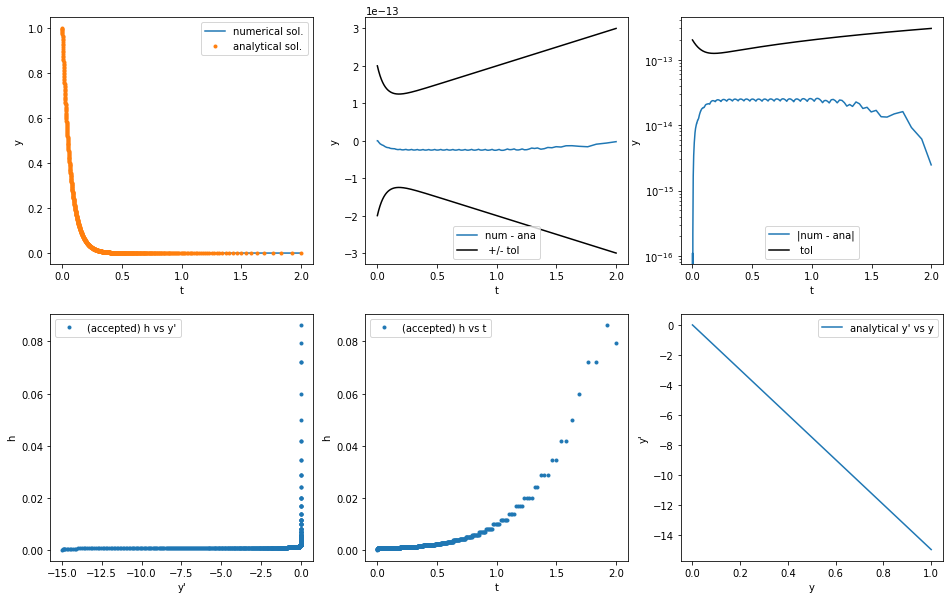

In [4]:

## absolute + cumulative + relative tolerance
tol_t = tol + tol*(t-t0) + tol * np.abs( y )

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots( 2, 3, figsize=(16,10) )

ax1.plot( t, y , label='numerical sol.' )
ax1.plot( t, solution(t), '.', label='analytical sol.')
ax1.set_xlabel('t')
ax1.set_ylabel('y')
ax1.legend()

ax2.plot(t, y - solution(t), label='num - ana')
ax2.plot(t, tol_t, color='k', label=' +/- tol' )
ax2.plot(t,-tol_t, color='k' )
ax2.set_xlabel('t')
ax2.set_ylabel('y')
ax2.legend(loc='lower center')

ax3.semilogy(t, np.abs(y - solution(t)), label='|num - ana|')
ax3.plot(t, tol_t, color='k', label=' tol' )
ax3.set_xlabel('t')
ax3.set_ylabel('y')
ax3.legend(loc='lower center')

ax4.plot( problem(t,y)[1:], h[1:], '.', label="(accepted) h vs y'" )
ax4.set_xlabel("y'")
ax4.set_ylabel('h')
ax4.legend()

ax5.plot( t[1:], h[1:], '.', label="(accepted) h vs t" )
ax5.set_xlabel('t')
ax5.set_ylabel('h')
ax5.legend()

#### ####
exact_t = np.linspace(t0,max_t,1024)
exact_y = solution(exact_t)
exact_yp = problem(exact_t, exact_y)

ax6.plot( exact_y, exact_yp, label="analytical y' vs y" )
ax6.set_xlabel('y')
ax6.set_ylabel("y'")
ax6.legend()


plt.show()